# Natural Language Processing

### 2.1 Distributional Semantics, Latent Semantic Analysis and Word2Vec
<br><br>
Prof. Iacopo Masi and Prof. Stefano Faralli

In [1]:
import matplotlib.pyplot as plt
import scipy
import random
import numpy as np
import pandas as pd
pd.set_option('display.colheader_justify', 'center')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#plt.style.use('seaborn-whitegrid')

font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


# Aux functions

def plot_grid(Xs, Ys, axs=None):
    ''' Aux function to plot a grid'''
    t = np.arange(Xs.size) # define progression of int for indexing colormap
    if axs:
        axs.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        axs.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        axs.axis('scaled') # axis scaled
    else:
        plt.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        plt.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        plt.axis('scaled') # axis scaled
        
def linear_map(A, Xs, Ys):
    '''Map src points with A'''
    # [NxN,NxN] -> NxNx2 # add 3-rd axis, like adding another layer
    src = np.stack((Xs,Ys), axis=Xs.ndim)
    # flatten first two dimension
    # (NN)x2
    src_r = src.reshape(-1,src.shape[-1]) #ask reshape to keep last dimension and adjust the rest
    # 2x2 @ 2x(NN)
    dst = A @ src_r.T # 2xNN
    #(NN)x2 and then reshape as NxNx2
    dst = (dst.T).reshape(src.shape)
    # Access X and Y
    return dst[...,0], dst[...,1]


def plot_points(ax, Xs, Ys, col='red', unit=None, linestyle='solid'):
    '''Plots points'''
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='gray', linestyle="--")
    ax.axvline(x=0, color='gray',  linestyle="--")
    ax.plot(Xs, Ys, color=col)
    if unit is None:
        plotVectors(ax, [[0,1],[1,0]], ['gray']*2, alpha=1, linestyle=linestyle)
    else:
        plotVectors(ax, unit, [col]*2, alpha=1, linestyle=linestyle)

def plotVectors(ax, vecs, cols, alpha=1, linestyle='solid'):
    '''Plot set of vectors.'''
    for i in range(len(vecs)):
        x = np.concatenate([[0,0], vecs[i]])
        ax.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha, linestyle=linestyle, linewidth=2)

## My own latex definitions

$$\def\mbf#1{\mathbf{#1}}$$
$$\def\bmf#1{\boldsymbol{#1}}$$
$$\def\bx{\mbf{x}}$$
$$\def\bxt#1{\mbf{x}_{\text{#1}}}$$
$$\def\bv{\mbf{v}}$$
$$\def\bz{\mbf{z}}$$
$$\def\bmu{\bmf{\mu}}$$
$$\def\bsigma{\bmf{\Sigma}}$$
$$\def\Rd#1{\in \mathbb{R}^{#1}}$$
$$\def\chain#1#2{\frac{\partial #1}{\partial #2}}$$
$$\def\loss{\mathcal{L}}$$

# Very Brief Introduction

<img width="250" src="https://github.com/iacopomasi/iacopomasi.github.io/blob/master/imgs/iacopomasi_res.jpg?raw=true">

## 👨🏼‍🏫 About Me

- **Associate Professor** with Sapienza since late 2020
- **Adjunct Research Assistant Professor** with University of Southern California (USC), Los Angeles **till August 2022**

- Worked as Research Scientist on big DARPA projects (Dept. of Defense) of USA.


- My Background:
 - Computer Vision
 - Machine Learning


# I do research in AI

## Biometrics, Face Recognition, Adversarial Robustness, Generative Models 
### Mainly visual domain (images) but I am broadening my range (e.g. NLP!) 😛



# My Path
<div align='center'><img src="figs/path.png" width='80%'></div>

# Latest Research Effort (w/ USC, UCLA, Sapienza)
## Image Synthesis by Inverting a Quasi-Robust Classifier in AAAI-23
<div align='center'><img src="figs/aaai23.png" width='50%'></div>

# Stanford NLP Course 
<div align='center'><img src="figs/stanford.png" width='85%' ></div>


# Sapienza NLP Course

<div align='center'><img src="figs/sapienza_nlp.png" width='85%' ></div>

# Today's lecture
## - From Sparse to Distributed Representations
## - Latent Semantic Analysis (LSA)
## - Introduction to Word2Vec

# This lecture material is taken from
📘 **Chapter 5 and 6 Jurafsky Book**

📘 **Chapter 14.5 Eisenstein Book**
- [Stanford Slide Word2Vec](http://web.stanford.edu/class/cs224n/slides/cs224n-2022-lecture01-wordvecs1.pdf)
- [Stanford Lecture Word2Vec](https://www.youtube.com/watch?v=rmVRLeJRkl4&list=PLoROMvodv4rOSH4v6133s9LFPRHjEmbmJ&index=1)
- [Stanford Notes on Word2Vec](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf)

**LSA** part is taken from **[Introduction to Information Retrieval by Manning](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf)**

**Truncated SVD** from [sklearn](https://scikit-learn.org/stable/modules/decomposition.html#truncated-singular-value-decomposition-and-latent-semantic-analysis)

📝 Research papers on word2vec:
- [First paper: word2vec + hierarchical softmax](https://arxiv.org/pdf/1301.3781.pdf)
- [Negative Sampling paper](https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)

# Word2vec and Distributed Representations

- Word2vec is a method for learning **distributed representations** of words (also called **word embeddings**).
- These representations capture the **meanings of words** in a continuous vector space, where similar words are mapped to nearby points.
- This allows words to be used in natural language processing tasks like **language translation** and **text classification**, in a way that reflects their meanings.

# Word2vec and Distributed Representations

- Distributed representations are useful because they **encode words in a way that preserves relationships** between them.
- Word2vec uses a **shallow neural network** to learn these representations from large amounts of unannotated text data.
- The word2vec model has two main learning algorithms: **continuous bag-of-words (CBOW)** and **skip-gram**. These algorithms have different strengths and are suitable for different tasks.

...but there is a problem with the slides before 🤨 

...does anyone spot any problem?

well, they have been generated by a **large NLP language model optimized for dialogue 🤖**

# ChatGPT, if you do not believe me

<br>
<div align='center'><img src="figs/chatgpt_01.png" width='45%' ></div>


# To keep you motivated, let me entertain you...

Let's try latest NLP success **[ChatGPT](https://chat.openai.com/chat) by OpenAI**
<br><br>
<div align='center'><img src="figs/chatgpt_02.png" width='45%' ></div>

# NLP


- Human (natural) language is different than Computer (Artificial) languages
- Human language is a system specifically constructed to **convey meaning**
- Vision is produced by a **physical manifestation of a signal**, **NLP is not**
- Human language uses symbols to indicate extra-linguistic entities

<br><br>
<center>
<h2>Word : Signifier = Idea : Signified</h2>
<h2>"tree" = {🎄,🌳,🌴,🌲,🏝,}</h2>
</center>


<br>

_Stat rosa pristina nomine, nomina nuda tenemus_

# NLP models discrete symbols


- Vision and Audio are modeled as continuous signals that are then discretized (e.g. images)
- NLP instead is a **discrete/symbolic/categorical** domain.
    - This is why so far you have seen a lot of `count()`. 
    - All the math involved in NLP is mostly **discrete math**.

# Let's take a quick grasp of the difference between NLP and Vision

# Let's sample from a English Corpus

In [3]:
# downloaded from https://www.nltk.org/nltk_data/
# https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/words.zip
with open('data/en-basic.txt') as fr: words = fr.read().split('\n')

```python
print(*random.choices(words, k=100), sep=' ')
```

# "Unigram" model (no use of frequency)

Sampling from a corpus of **#{{len(words)}} words**

```
{{random.seed(42);print(*random.choices(words,k=100), sep=' ')}}
```

The text **globally does not make sense** but we still understand each word.

At times, **a few parts seem almost meaningful**:
- `and enough deep secret`
- `warm the fire property`
- `so industry basket`

# now  with Vision

Image shape is (120, 120, 4) --> HxWx(RGBA)


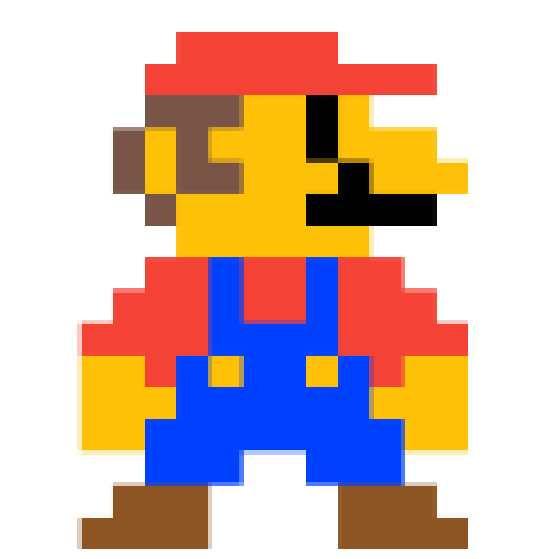

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('data/mario.png')
plt.figure(figsize=(7,7));
imgplot = plt.imshow(img)
plt.axis('off');
print(f'Image shape is {img.shape} --> HxWx(RGBA)');

# Vision

Mario below is an instance in space of $\mathbb{Z}_{[0,255]}^{120\times120\times3}$,  if we do not consider the alpha channel.
- each pixel takes value in $[0,255]$
- we have HxWx3 cell grid to fill

<center>
{{plt.figure(figsize=(5,5));_=plt.imshow(img);_=plt.axis('off');}}
</center>

# Let's sample randomly in the "visual" space

```python
import numpy as np
rand_im = random.choices(range(0, 256), k=120*120*3)
rand_im = np.array(rand_im).reshape(120, 120, 3)
imgplot = plt.imshow(rand_im)
plt.axis('off');
```
## What would you expect?

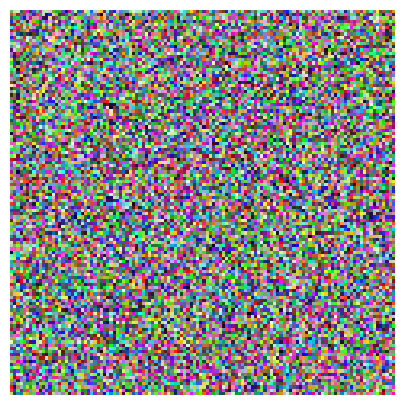

In [5]:
import numpy as np
rand_im = random.choices(range(0, 256), k=120*120*3)
rand_im = np.array(rand_im).reshape(120, 120, 3)
plt.figure(figsize=(5,5))
imgplot=plt.imshow(rand_im)
_=plt.axis('off')

# Much more non-sense than with text, right?


# Vision

- No notion of discrete symbols. What is the semantic of a pixel?
- Continuous signal that is discretized on a grid

# NLP meets Vision will return at the end of the course

#  A bit of Linguistics to start

Definition of mouse from a dictionary:
```text
mouse (N)
1.  any of numerous small rodents...
2.  a hand-operated device that controls a cursor...
```

- **mouse** is called a **lemma or citation form**; for verbs usually the **lemma** is the infinite form
- **mice**  is a **wordform** (in this case the, irregular, plural form of mouse)

# Word Sense

Multiple aspects of the meaning of a word

```text
mouse (N)
1.  any of numerous small rodents...
2.  a hand-operated device that controls a cursor...
```

without **context** it is difficult to say if `mouse` refers to `1.` or `2.`


<div align='center'><img src="figs/mouse.png" width='45%' ></div>

<div align='center'><img src="figs/mouse_animal.png" width='45%' ></div>

# Word Sense Disambiguation

<div align='center'><img src="figs/google.png" width='45%' ></div>

# Synonym

- One important component of **word meaning** is the relationship between word senses. 
- For example when **one word has a sense whose meaning** is _identical_ to a **sense of another word** we say the two senses of those two words are **synonyms**.

| **Word A** 	| **Word B** 	|
|:----------:	|-----------:	|
| couch      	|       sofa 	|
| car        	| automobile 	|
| hazelnut   	|    filbert 	|

# Word Similarity: what this lecture is about

- While words do not have many synonyms, most words do have lots of similar words
- Cat is not a synonym of dog, but **cats and dogs are certainly similar words** (for sure more than **cat vs airplane**)
- The notion of **word similarity** is very useful in larger semantic tasks

|       |            |         |
|:----- | -------:   | -------:	
vanish 	| disappear  | 9.8 
belief  | impression | 5.95
muscle  | bone       | 3.65 
modest  | flexible   | 0.98
hole 	| agreement  | 0.3  

# Representing Words as Discrete Symbols: One-Hot Encoding

In traditional NLP, we regard words as discrete symbols.

`hotel, conference, motel` can be represented with a vector $\bx$:
- of dimension $|V|$
- each component indexes a word in the vocabulary $V$
- if we are dealing with a word present in $V$ at index $i$ then:

$$
\bx_j = \begin{cases} 1, & \mbox{if } i=j \\
                       0  & \forall j \neq i
          \end{cases}
$$

visually this is something as:

   0   |   0   |   0   |    0   |   1    |   ...    |    0   |       |       |       |
:----- |:----- |:----- |:----- |:----- |:----- |:----- |:----- |:----- |:----- |
 cat   |  airplane     |   dog     |  beer     |  hotel      |  ....     |   garden    |       |       |       |




# Representing Words as Discrete Symbols: One-Hot Encoding

In traditional NLP, we regard words as discrete symbols.

`hotel, conference, motel` can be represented with a vector $\bx$:
- of dimension $|V|$
- each component indexes a word in the vocabulary $V$
- if we are dealing with a word present in $V$ at index $i$ then:

$$
\bx_j = \begin{cases} 1, & \mbox{if } i=j \\
                       0  & \forall j \neq i
          \end{cases}
$$

More formally:
$$
\bxt{hotel} = \underbrace{[0~0~0~0~1~0~0\ldots 0~0~0~0~0~0]}_{|V|}
$$




Is the same as saying that the word `hotel` appears at index 4 in the vocabulary (starting from zero)

# Brief recap on Linear Algebra

# Vectors: Geometric Interpretation 1 
## Point in space

- Given a vector, the first interpretation
that we should give it is as a **point in space.**

- In two or three dimensions, we can visualize these points
by using the components of the vectors to define
the location of the points in space compared
to a fixed reference called the *origin*.

<img class="center" src="https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/grid-points.svg" width="30%">


##### Formalizing problems
This geometric point of view allows us to consider the problem on a more abstract level.
No longer faced with some insurmountable seeming problem
like classifying pictures as either cats or dogs but separate points in space.

`Problem -> Formalization -> Math -> Computational System`

<small>Taken from [d2l.ai](https://d2l.ai)<small>

# Vectors: Geometric Interpretation 2 
## Direction in space

In parallel, there is a second point of view
that people often take of vectors: **as directions in space.**
Not only can we think of the vector $\mathbf{v} = [3,2]^\top$
as the location $3$ units to the right and $2$ units up from the origin,
we can also think of it as the direction itself
to take $3$ steps to the right and $2$ steps up.
In this way, we consider all the vectors in figure the same.
<img src="https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/par-vec.svg" width="30%">

## Direction in space

One of the benefits of this shift is that
we can make visual sense of the act of vector addition.
In particular, we follow the directions given by one vector,
and then follow the directions given by the other, as is seen below.

<img src="https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/vec-add.svg" width="30%">

Difference is just $\mathbf{A}-\mathbf{B}=\mathbf{A}+(-\mathbf{B})$

<small>Taken from [d2l.ai]<small>

# Inner Product (Dot Product)

\begin{equation} \mathbf{x}, \mathbf{y} \in \mathbb{R}^D ~~~~~~~~~\quad 
\mathbf{x}^T \mathbf{y} = \left\langle\mathbf{x}, \mathbf{y}\right\rangle = \sum_i^D \mathbf{x}_i \cdot \mathbf{y}_i
\end{equation}

```
x1 x2 x3 x4 
           y1
           y2   =    result (dot_product)
           y3
           y4


dot_product = x1y1 + x2y2 + x3y3 + x4y4
```

- The result is a **scalar** (not a vector anymore).
- $\mathbf{x}, \mathbf{y}$ must live in the same dimension
- It is **commutative**
- The data is **paired**: just muliply elementwise and sum across axis.

# Inner product: Geometric Interpretation

- The dot product also admits a geometric interpretation: **it is closely related to the angle between two vectors.** 
- It is biased by the norm ("length") of the vectors (it favors "long" vectors)


<img src="https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/vec-angle.svg" width="30%">

$$
\mathbf{v}\cdot\mathbf{w} = \|\mathbf{v}\|\|\mathbf{w}\|\cos(\theta).
$$

With some simple algebraic manipulation, we can rearrange terms to obtain

$$
\theta = \arccos\left(\frac{\mathbf{v}\cdot\mathbf{w}}{\|\mathbf{v}\|\|\mathbf{w}\|}\right).
$$


This is a nice result since nothing in the computation references two-dimensions.

**Indeed, we can use this in three or three million dimensions without issue.**

### Cosine Similarity
In ML contexts where the **angle is employed
to measure the closeness of two vectors**,
practitioners adopt the term **cosine similarity**
to refer to the portion
$$
\cos(\theta) = \underbrace{\frac{\mathbf{v}\cdot\mathbf{w}}{\|\mathbf{v}\|\|\mathbf{w}\|}}_{\text{cosine similarity}}.
$$

- What happens if cosine similarity is 1?
- Notice any similarity with some concept we saw in previous lecture?

# The problem of Dot Product and One-Hot Encoding

Assume a vocabulary of words $V$

$$
\bxt{motel} =  
\begin{bmatrix}
0 \\
1 \\
\ldots, \\
0 \\
\end{bmatrix} \quad
\bxt{hotel} =  
\begin{bmatrix}
0 \\
1 \\
\ldots, \\
0 \\
\end{bmatrix} \quad \ldots
\quad
\bxt{car} =  
\begin{bmatrix}
0 \\
1 \\
\ldots, \\
0 \\
\end{bmatrix}
$$

 $$ \bxt{motel}^T \bxt{hotel} = \bxt{motel}^T\bxt{car}=0$$
 
There is no notion of similarity and vectors are very long--size of $|V|$.

# The Distributional Hypothesis

<div align='center'><img src="figs/firth.png" width='10%' ></div>
    
Stated by J. R. Firth (1957) as: 

> "You shall know a word by the company it keeps"

Distributional statistics have a striking ability to capture lexical semantic relationships such as **analogies**.

# Distributional statistics and unsupervised learning

The distributional hypothesis has stood the test of time: 
- distributional statistics are a core part of language technology today
- they make it possible to leverage large amounts of **unlabeled data** to learn about rare words that do not appear in labeled training data

# The meaning of the word `tezguino`

<div align='center'><img src="figs/tezguino.png" width='45%' ></div>

# The context plays a big role

We evince that `tezguino` may be an **alcoholic beverage made from corn mash.**

<div align='center'><img src="figs/tezguino.png" width='45%' ></div>

# Long, Sparse

- One-Hot Encoding
- TF-IDF
- Term-Document matrix
- PPMI (Point-wise Mutual Information)

# Short, Dense

- Latent Semantic Analysis (LSA)
- word2vec

# Long, Sparse: Term-Document Matrix

```python
corpus = [
    'This document is the second document.', #document 0
    'And this is the third one.',            #document 1
    'Is this the first document?',           #document 2
]
```

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This document is the second document.', #0
    'And this is the third one.',            #1
    'Is this the first document?',           #2
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
td_matrix=pd.DataFrame(data=X.todense(), 
             index=[f'doc-{i}' for i in range(X.shape[0])],
             columns=vectorizer.get_feature_names_out(),)

# Term-Document Matrix

$|V|=9$ is the vocabulary size and $|D|=3$ is the number of documents

$$ \text{count}(t,d)\quad  t \in V$$

{{td_matrix}}

You can interpret it two ways:
1. $|D|=3$ documents vectors that lives in a $|V|$ dimensional space (row-wise)
    - An axis of the space indicates a **word**
2. $V$ word vectors that lives in a $|D|=3$ dimensional space (column-wise)
    - An axis of the space indicates a **document**

# Long, Sparse: TF-IDF Matrix

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This document is the second document.', #0
    'And this is the third one.',            #1
    'Is this the first document?',           #2
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tfidf_matrix=pd.DataFrame(data=X.todense(), 
             index=[f'doc-{i}' for i in range(X.shape[0])],
             columns=vectorizer.get_feature_names_out(),)

# TF-IDF Matrix

$$\text{tf}(t,d) = \log_{10}\big(\text{count}(t,d)+1\big)\quad \text{idf}(t) = \log_{10}\Big(\frac{|D|}{\text{df(t)}}\Big)\quad  df(t)= \sum_{d=1}^{|D|} \mathbb{1}[t \in d] $$

$$ \text{w}(t,d) \doteq \text{tf}(t,d) \cdot \text{idf}(t)   $$
{{tfidf_matrix}}

# How do we go Short and Dense?

# How do we go Short and Dense?

> "You shall know a word by the company it keeps"

**Word embeddings (dense)** are estimated by **optimizing some objective**: the reconstruction of a matrix of context count or the likelihood of a set of unlabeled data.

1. **[Latent Semantic Analysis (LSA)]** Factorize your count matrix $\mbf{X}$ by minimizing its reconstruction $|| \mbf{X} - \mbf{X}(\mbf{u},\mbf{v})||_F$ and learning $\mbf{u}$ document embedding and $\mbf{v}$ word embedding
2. **[Word2vec]** we optimize the likelihood-based optimization of a model that encodes word embeddings over a corpus of training data with self-supervision.


# Latent Semantic Analysis (LSA)

Sometimes it is called *Latent Semantic Indexing (LSI)*

# Latent Semantic Analysis (LSA)

It is related to different concept of machine learning and unsupervised learning

- Eigendecomposition and Singular Value Decomposition (SVD)
- Dimensionality reduction (I have features in $N$ dimensional space I want to reduce it to $M$ dimensions $M\ll N$)
- **Finding latent topics in text in an unsupervised way**
- From long, sparse representation to **short, dense**

# Decompose a matrix

Assume $\mathbf{X}$ is your term-document or tf-idf matrix computed over a corpus.

$\mathbf{X}$ dimension is $|D| \times |V|$ so it captures some form of correlation between:
 - term vs term in a vector space defined by documents
 - document vs document in a vector space define by terms

**Key idea 1:** Assume there are $k$ hidden topics that we do not know about, but seek for discovering them in unsupervised way.

**Key idea 2:** Do not look at  $\mathbf{X}$ simply as raw data yet decompose it in a way that **the decomposition gives you information and imposes constraints.**

# Decompose with SVD (Singular Value Decomposition)

For now we simply seek to decompose $\mathbf{X} = \mathbf{U}\mathbf{S}\mathbf{V}^{\top}$

$\mathbf{X} \in \mathbb{R}^{|D| \times |V|} \qquad = \qquad {\mathbf{U} \in \mathbb{R}^{|D| \times |D|}, ~~\mathbf{S} \in \mathbb{R}^{|D| \times |V|},~~ \mathbf{V} \in \mathbb{R}^{|V| \times |V|}}$

<br>
\begin{equation}
\begin{aligned}
\arg\min_{\mathbf{U},\mathbf{S},\mathbf{V}}  & \left\|\mathbf{X}-\mathbf{U S V}^{\top}\right\|_F \\
\text { s.t. } & \mathbf{U}^{\top} \mathbf{U}=\text{Id} \quad \mathbf{V}^{\top} \mathbf{V}=\text{Id} \\
& \mathbf{S}=\text{diag}(\lambda_1,....\lambda_s)\\
& \text{we seek  }  \mathbf{U}\mathbf{S}\mathbf{V}^{\top} \text{to be low-rank}
\end{aligned}
\end{equation}

##### Property
- $\mathbf{U}^{\top} \mathbf{U}=\text{Id}$ **orthonormality constraints** that all pairs of dimensions in U and V are uncorrelated, so that each dimension conveys unique information
- $\mbf{S}$ is a diagonal matrix containing the ordered singular values (denote the **importance** of each axis in the new  space)

# SVD Visually

<div align='center'><img src="figs/tsvd.png" width='65%' ></div>

# Low-rank approximation of the data with Truncated SVD

**Key idea:** We assume there might be $k \ll D$ latent topics in your data matrix $\mbf{X}$.
- We use **SVD** but now approximate $\mbf{X}$ by **just considering the highest singular values**
- In some sense, it is a way of saying we consider most of the variations in the data; 
- small variations may be related to noise and so we "throw them away".

$$\mbf{X} \approx \mbf{X}_k = \mbf{U_k S_k V_k}^{\top}$$
<br><br><br>
<div align='center'><img src="figs/mysvd.png" width='65%' ></div>

# Truncated SVD - Low-rank approximation

<div align='center'><img src="figs/tsvd2.png" width='75%' ></div>

In [8]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

# Let's look at the data

- Newsgroup text from the '90s (internet was not there yet)
- We have the **categories** but $\underline{\text{we set them aside from the algorithm}}$
- We assume **we do NOT know the categories of the text**
    - We seek to recover them in an unsupervised way
Categories are `{{newsgroups_train.target_names}}`

```python
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)
```

In [9]:
print(*newsgroups_train.data[:3], sep='\n'+'=='*50+'\n')

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

# From raw text to Term-Document Matrix

# From raw text to Term-Document Matrix

```python
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(newsgroups_train.data)
X_train_counts.shape # (documents, vocab)
```

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(newsgroups_train.data)
dims = X_train_counts.shape # (documents, vocab)
print(f'We have {dims[0]} documents and a vocabulary of size {dims[1]}')

We have 2034 documents and a vocabulary of size 26576


# Term-Document Matrix Shape

X_train_counts shape is {{X_train_counts.shape}}

- {{X_train_counts.shape[0]}} individual documents (in this case newsgroup posts)
- {{X_train_counts.shape[1]}} the number of terms (i.e. vocabulary size $|V|$)
- Note that `X_train_counts` is modeled as a sparse matrix `{{type(X_train_counts)}}`

Let us see a few $k=10$ random words from the vocabulary:
```python
random.choices(count_vect.get_feature_names_out(), k=10) #k is the number of samples
```

{{random.seed(0); random.choices(count_vect.get_feature_names_out(), k=10)}}

In [11]:
td_matrix = pd.DataFrame(data=X_train_counts.todense(), 
                         index=range(X_train_counts.shape[0]),
                         columns=count_vect.get_feature_names_out(),)

{{td_matrix}}

# Sanity check and see the most frequent word

```python
r, c = np.unravel_index(np.argmax(X_train_counts), X_train_counts.shape)
print(count_vect.get_feature_names_out()[c], 
      'occurred', X_train_counts[r, c], 'times')
```

In [12]:
r, c = np.unravel_index(np.argmax(X_train_counts), X_train_counts.shape)
print(count_vect.get_feature_names_out()[c], 'occurred', X_train_counts[r, c], 'times')

jpeg occurred 232 times


In [13]:
#%time U, S, V = np.linalg.svd(X_train_counts.todense(), full_matrices=False)

In [14]:
#%time Us, Ss, Vts = scipy.sparse.linalg.svds(X_train_counts.asfptype(), k=X_train_counts.shape[0]-1)

In [15]:
%time Us, Ss, Vts = scipy.sparse.linalg.svds(X_train_counts.asfptype(), k=2)

CPU times: user 71.9 ms, sys: 5.13 ms, total: 77 ms
Wall time: 40.3 ms


In [16]:
print("U = ", (Us.shape), "S = ",  (Ss.shape), "V = ",  (Vts.shape))

U =  (2034, 2) S =  (2,) V =  (2, 26576)


# 1. Singular Values give you the  "topic" importance
$S=${{Ss}}
{{_=plt.bar([1,2],Ss)}}

# 2. The embedding space ($k=2$)

- Unlike before, it is now **continuous, short and dense**
- The space encodes some notion of similarities between words
- Cosine similarity makes more sense

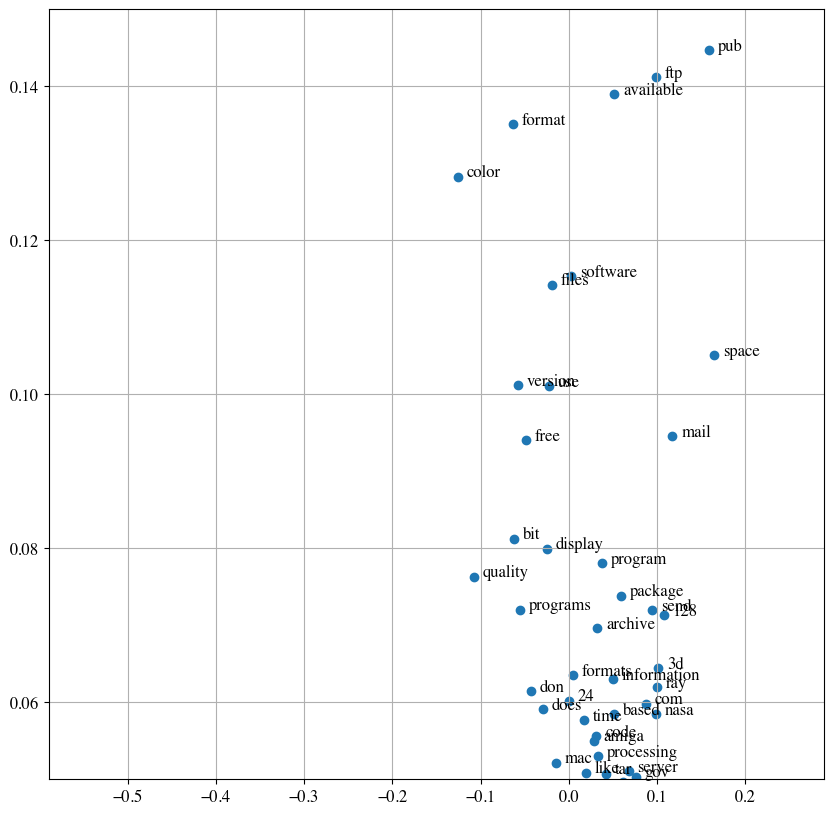

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
clip = 1
ax.scatter(*Vts);
vocab = count_vect.get_feature_names_out()
for count, ((x,y), txt) in enumerate(zip(Vts.T, vocab)):
    if np.linalg.norm([x,y]) > .5e-1:    
        ax.annotate(txt, (x+0.01, y))
if clip:
    #plt.ylim(-0.175, -0.030)
    plt.ylim(0.05, 0.15)
plt.grid('off')

# 3. We can associate each new $k$ component (topic) with most important words

<br><br>
<div align='center'><img src="figs/mysvd.png" width='65%' ></div>

# 3. We can associate each new $k$ component (topic) with most important words using $\mbf{V}_k$
<br>
<div align='center'><img src="figs/mysvd2.png" width='35%' ></div>

In [18]:
k=0 #first component, first topic
word_per_topic = 10
topic = [vocab[idx_word] for idx_word in np.argsort(Vts[k,:])[:-word_per_topic-1:-1]]
topic_weight = np.sort(Vts[k,:])[:-word_per_topic-1:-1]
topic_neg = [vocab[idx_word] for idx_word in np.argsort(Vts[k,:])[:word_per_topic:]]
#topic

# Topic $k=0$ associated with singular value $\lambda_0$ = {{round(Ss[0])}}
```python
word_per_topic = 10
topic = [vocab[idx_word] for idx_word in np.argsort(Vts[k,:])[:-word_per_topic-1:-1]]
```

{{pd.DataFrame(data=[topic])}}

####  Weights
{{pd.DataFrame(data=[topic_weight])}}

####  Negative terms 
{{pd.DataFrame(data=[topic_neg])}}

In [19]:
k=1 #second component, first topic
topic = [vocab[idx_word] for idx_word in np.argsort(Vts[k,:])[:-word_per_topic-1:-1]]
topic_weight = np.sort(Vts[k,:])[:-word_per_topic-1:-1]
topic_neg = [vocab[idx_word] for idx_word in np.argsort(Vts[k,:])[:word_per_topic:]]
#topic

# Topic $k=1$ associated with singular value $\lambda_1$ = {{round(Ss[1])}}
```python
word_per_topic = 10
k=1;topic = [vocab[idx_word] for idx_word in np.argsort(Vts[k,:])[:-word_per_topic-1:-1]]
```

{{pd.DataFrame(data=[topic])}}

####  Weights
{{pd.DataFrame(data=[topic_weight])}}

####  Negative terms 
{{pd.DataFrame(data=[topic_neg])}}

# How to think about the new embedding space

If you reduce the dimension from 3 to 2, you may think that the embedding is learning something like:

$$[\text{car}, \text{truck}, \text{flower}] \longrightarrow [(1.3452 * \text{car} + 0.2828 * \text{truck}), \text{flower}]$$

# 4. Dimensionality Reduction: 
## Projecting a document into lower-dimensional space

We treat the document as a vector $\mbf{d}$ that lives in a $V$ dimensional space. 
- We want to use the output of SVD to project $\mbf{d}$ from V dimension to $k$ where $k\ll V$. 
- Usually $k$ is the order of hundreds.

We take the matrix $\mbf{V}_k$ of the SVD decomposition that has dimension $k\times V$ (this makes sense because $\mbf{d}$ lives in the same $V$-D space too).
$$ \mbf{d}_k = \underbrace{\mbf{V}_k^{\top}}_{k\times V}\underbrace{\mbf{d}}_{V}$$

#  Why SVD?

Consider $X$ has `term by document` matrix.

\begin{matrix} 
 & \textbf{d}_j \\
 & \downarrow \\
\textbf{t}_i^T \rightarrow &
\begin{bmatrix} 
x_{1,1} & \dots & x_{1,j} & \dots & x_{1,n} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
x_{i,1} & \dots & x_{i,j} &  \dots & x_{i,n} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
x_{m,1} & \dots & x_{m,j} & \dots & x_{m,n} \\
\end{bmatrix}
\end{matrix}

- Assuming that you have $\ell_2$ normalized vectors, you can compute the **similarity** between two terms by evaluating the dot product $\textbf{t}_i^T\textbf{t}_j$
- If you want to compute it for all pairs just compute the covariance matrix: $\mbf{X}\mbf{X}^{\top}$ which measure all the **correlations between terms in the document space.**

# Why SVD: decompose correlation of the data

$\mbf{X}\mbf{X}^{\top}$ which measures all the **correlations between terms in the document space.** What if we decompose this correlation?

\begin{matrix}
\mathbf{X} \mathbf{X}^T &=& (\mathbf{U} \mathbf{S} \mathbf{V}^T) (\mathbf{U} \mathbf{S} \mathbf{V}^T)^T = (\mathbf{U} \mathbf{S} \mathbf{V}^T) (\mathbf{V}^{T^T} \mathbf{S}^T \mathbf{U}^T) = \mathbf{U} \mathbf{S} \mathbf{V}^T \mathbf{V} \mathbf{S}^T \mathbf{U}^T = \mathbf{U} \underbrace{\mathbf{S} \mathbf{S}^T}_{\Sigma} \mathbf{U}^T  \\
\end{matrix}

Singular Value Decomposition of $\mathbf{X}$ is related to **Eigendecomposition** of the covariance of $\mathbf{X}$. 

Eigenvalue $\sigma_i = \lambda_i^2 \quad\longrightarrow\quad$ Eigenvalue = squared singular value

# Eigendecomposition and Singular Value Decomposition

| Method 	| X 	| Decomposition 	|
|--------	|---	|---------------	|
|     SVD   | any  	|   $\mbf{X}=\mbf{U}\mbf{\Sigma}\mbf{V}^{\top}$            	|
|     Eigen   | square  	|   $\mbf{X}=\mbf{U}\mbf{\Sigma}\mbf{U}^{-1}$            	|

# Decomposition as a Geometric Pipeline

$$\mathbf{A}\mathbf{x} = \underbrace{(\mathbf{U} 
\underbrace{(\mathbf{\Sigma}\underbrace{(\mathbf{U}^{-1}\mathbf{x})}_{\text{1st step/rotate}})}_{\text{2nd step/scale}})}_{\text{3rd step/rotate}}$$

| Method   	| Step 1 	| Step 2             	| Step 3 	|
|----------	|--------	|--------------------	|--------	|
| Geometry 	| rotate 	| scale/reflect axis 	| rotate 	|
| SVD      	|   $\mbf{V}^T$     	|   $\mbf{\Sigma}$                 	|  $\mbf{U}$      	|
| Geometry 	| rotate 	| scale/reflect axis 	| rotate 	|
| Eig      	|  $\mbf{V}^{-1}$        	|     $\mbf{\Sigma}$                 	| $\mbf{U}$         	|

# Problems with LSA and SVD

The dimensions of the matrix change very often (new words are added very frequently and corpus changes in size). 
SVD based methods do not scale well for big matrices and it is hard to incorporate new words or documents.
- The matrix is extremely sparse since most words do not co-occur.
- The matrix is very high dimensional in general (≈ $10^6 × 10^6$)
- Quadratic cost to train (i.e. to perform SVD)
- Requires the incorporation of some hacks on X to account for the drastic imbalance in word frequency

# Applications: Topic modeling with Gensim
<br/>
<div align='center'><img src="figs/gensim.png" width='65%' ></div>

# Gensim library

- Free python library for topic modeling
- It contains **LSA** and also **word2vec**
- No deeplearning yet!

<div align='center'><img src="figs/gen_sim_lsa.png" width='65%' ></div>



# Introduction to word2vec

# Introduction  to word2vec

Word2vec [Mikolov et al. 2013] is a framework for **learning word vectors**. 

The objective is the same to what we saw in **LSA**.

# Introduction to word2vec

- Still learn short, dense and static embeddings.
- Static embeddings: one fixed embedding for each word in the vocabulary

Idea: apply **machine learning** and use the text as **self-supervision**

>The intuition of word2vec is that instead of counting how often each word w occurs near, say, apricot, we’ll instead train a classifier on a binary prediction task: “Is
word w likely to show up near apricot?” We don’t actually care about this prediction
task; instead we’ll take the learned classifier weights as the word embeddings.

# Recap of concepts to understand word2vec

- Self-Supervision
- Binary Logistic Regression
- Softmax classifier (Multinomial Logistic Regression)
- Optimization with Gradient Descent

# Self-Supervision

Let's play a game and fill the missing word:

```
Yesterday, it was a hot summer day in Rome, so I went to a nice 
gelateria and I bought a delicious yet melting ____________
```
<br/>

| word1   	| word2 	| word3             	| word4	| sum | 
|----------	|--------	|--------------------	|--------	| --------	|
| strolley | ice-cream | parrot|  gelato| |
| prob=? | prob=? | prob=?|  prob=?| 1 |

**Masking the input:** with self-supervision you have the ground-truth word because it is in the text itself. You simple remove a word and ask the machine to predict the removed word, given some context.



# Logistic Regression

- The name is a bit _misleading_: it is used as a **discriminative <ins>classifier<ins>**
- Discriminative means we model $p(y|x)$ _what is the probability for the label $\operatorname{prob}(Y=y)$ given $x$?_
- Very commonly used algorithm

# Logistic Regression

- $\mbf{x} \in \mathbb{R}^d \quad y \in \{0,1\}$

$$ \begin{cases}
y=1  \quad \text{positive example}\\
y=0 \quad \text{negative example}\\
\end{cases} $$

# Logistic Regression (also called Logit)


$$f_{\boldsymbol{\theta}}(\mbf{x}) \doteq \sigma\left(  \bmf{\theta}^T\mbf{x} \right)$$

where:

$$ \sigma(z)= \frac{1}{1+\exp^{-z}} \quad \text{sigmoid or logistic function}$$
<br><br> <center>Smooth and Differentiable alternative to sign</center>
{{import numpy as np;import matplotlib.pyplot as plt;x = np.arange(-20.0, 20.0, 0.1);y = 1/(1+np.exp(-x));_=plt.plot(x,y);}}

# Logistic Regression - Probabilistic View

We model **conditional probability of $y|x$:**

$$ \begin{cases}
p(y=1| \mbf{x};\bmf{\theta}) = f_{\boldsymbol{\theta}}\\
p(y=0| \mbf{x};\bmf{\theta}) = ?\\
\end{cases} $$

<br><br>
$$f_{\boldsymbol{\theta}}(\mbf{x}) \doteq \sigma\left(  \bmf{\theta}^T\mbf{x} \right)$$

where:

$$ \sigma(z)= \frac{1}{1+\exp^{-z}} \quad \text{sigmoid or logistic function}$$


# Logistic Regression - Probabilistic View

We model **conditional probability of $y|x$:**

$$ \begin{cases}
p(y=1| \mbf{x};\bmf{\theta}) = f_{\boldsymbol{\theta}}\\
p(y=0| \mbf{x};\bmf{\theta}) = 1- f_{\boldsymbol{\theta}}\
\end{cases} $$

<br><br>
$$f_{\boldsymbol{\theta}}(\mbf{x}) \doteq \sigma\left(  \bmf{\theta}^T\mbf{x} \right)$$

where:

$$ \sigma(z)= \frac{1}{1+\exp^{-z}} \quad \text{sigmoid or logistic function}$$

$$\lim_{z\mapsto \infty}\sigma(z)=1$$
$$\lim_{z\mapsto -\infty}\sigma(z)=0$$

# Logistic Regression - Probabilistic View

We model **conditional probability of $y|x$:**

$$ \begin{cases}
p(y=1| \mbf{x};\bmf{\theta}) = f_{\boldsymbol{\theta}}\\
p(y=0| \mbf{x};\bmf{\theta}) = 1- f_{\boldsymbol{\theta}}\
\end{cases} $$

<br><br>
$$f_{\boldsymbol{\theta}}(\mbf{x}) \doteq \frac{1}{1+\exp^{-\bmf{\theta}^T\mbf{x}}}$$


# Multinomial Logistic Regression with SoftMax

We model **conditional probability of $y|x$:**

$$ \begin{cases}
p(y=1| \mbf{x};\mbf{W},\mbf{b}) = p_1 = \bmf{\sigma}_1\left(  \mbf{W}\mbf{x} + \mbf{b} \right)\\
p(y=2| \mbf{x};\mbf{W},\mbf{b}) = p_2 =  \bmf{\sigma}_2\left(  \mbf{W}\mbf{x} + \mbf{b} \right)\\
\ldots \\
p(y=K| \mbf{x};\mbf{W},\mbf{b}) = p_K =  \bmf{\sigma}_K\left(  \mbf{W}\mbf{x} + \mbf{b} \right)\\
\end{cases} $$

<br><br>
$$f_{\boldsymbol{\theta}}(\mbf{x}) \doteq \mbf{z} \doteq \bmf{\sigma}\left(  \mbf{W}\mbf{x} + \mbf{b} \right)$$

where:

$$ \bmf{\sigma}_i(z)= \frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}} \quad \text{Softmax function}$$


# How SoftMax transforms logits into probability

<div align='center'><img src="figs/softmax_prob.png" width='75%' ></div>

# SoftMax Regression, More Compact Form


you can think $\mbf{z} = \mbf{W}\mbf{x}+\mbf{b}$ as **unormalized log-probability** of each class.

<br>
$$ p(\mbf{y}| \mbf{x};\mbf{W},\mbf{b}) = \frac{\exp({\mbf{W}\mbf{x}+\mbf{b})}}{\sum_{k=1}^K\exp({\mbf{W}_k\mbf{x}+\mbf{b}_k)}} $$




# Learning weights through Stochastic Gradient Descent (SGD)

We need to minimize $$ \mathcal{J}(\mbf{\theta};\mbf{x},y)= \frac{1}{2} \sum_{i=1}^{n}\mathcal{L}\big(y_{i}, f_{\boldsymbol{\theta}}(\mbf{x}_i)\big)$$  so to find:

$$\mbf{\theta}^{\star} = \arg\min_{\mbf{\theta}} \mathcal{J}(\mbf{\theta};\mbf{x},y) $$

# Gradient Descent Algorithm as an Iterative Method

<ins>**Idea: make little step so that locally after each step the cost is lower than before**</ins><br>
Input: Training set $\{\mbf{x}_i,y_i\}$, learning rate  $\gamma$, a small value in $\{0.1,\ldots,\texttt{1e-6}\}$.

1. **Initialization - Very Important if the function is not strictly convex** 
$$\bmf{\theta} \doteq \mbf{0}^T$$ Set it to all zeros or random initialization from a distribution.
2. Repeat until **convergence**:
    - Compute the gradient of the loss wrt to the parameters $\bmf{\theta}$ given **all the training set**
    - Take a small step in the opposite direction of steepest ascent **(so steepest descent).**<br/><br/>
     $$\bmf{\theta} \leftarrow  \bmf{\theta} -\gamma \bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};\mbf{x},y)$$
3. When convergence is reached, you final estimate is in $\bmf{\theta}$

# Convergence

$$\big\{\bmf{\theta}_{t=0},\bmf{\theta}_{t=1}, \ldots, \bmf{\theta}_{t=100} \big\}$$

### 0) <ins>Always:</ins> validation loss/metric _(early stopping)_ (required)

### 1) No significant decrease in the loss function (preferred)

$$\mid \mathcal{J}(\mbf{\theta};\mbf{x},y)_{t} - \mathcal{J}(\mbf{\theta};\mbf{x},y)_{t-1}   \mid $$

### 1) No variations in the parameters

$$\mid\mid \mbf{\theta}_{t} - \mbf{\theta}_{t-1}   \mid\mid $$

### 2) Gradient Norm goes to zero

$$\mid\mid \bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};\mbf{x},y)   \mid\mid \rightarrow 0 $$


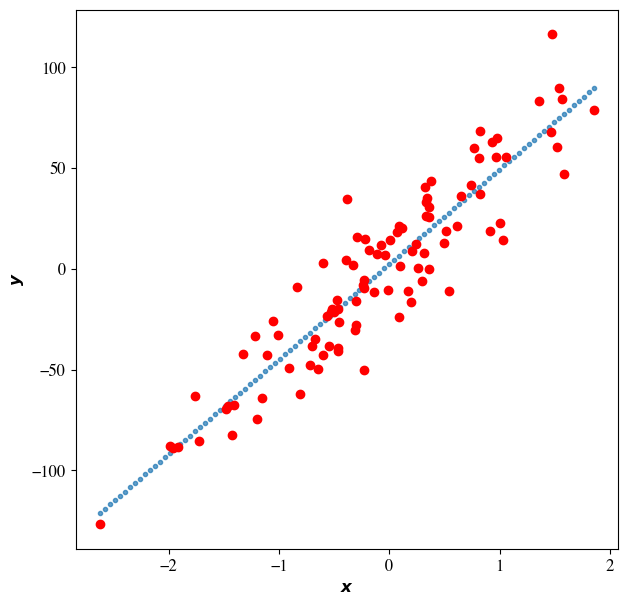

In [20]:
%matplotlib inline
from sklearn import linear_model, datasets
from matplotlib import pyplot as plt
import numpy as np

n_samples = 100
size = 7

X, y, coef_gt = datasets.make_regression(
    n_samples=n_samples,
    n_features=1,
    n_informative=1,
    noise=20,
    coef=True,
    random_state=42,
)
fig = plt.figure(figsize=(size, size))
ax = fig.add_subplot()
# Linear Regression
bias = np.ones((X.shape[0], 1))
X = np.hstack((X, bias))
theta = np.linalg.inv(X.T@X)@X.T@y
# Now MeshGrid
Xmin, Xmax = X.min(), X.max()
x_interp = np.linspace(Xmin, Xmax, 100)
x_interp = x_interp.reshape(-1,1)
x_interp = np.c_[x_interp,np.ones_like(x_interp)]
y_interp = np.dot(theta, x_interp.T)
ax.scatter(x_interp[:,0], y_interp, alpha=0.7, marker='.')
ax.scatter(X[..., 0], y, c='red', marker='o')
ax.set_xlabel('$x$');
ax.set_ylabel('$y$');

In [21]:
# do mesh grid on possible theta, evaluate the loss and plot the countf
theta_sampling = 50
theta_space = np.linspace(-200, 200, theta_sampling)
xxt, yyt = np.meshgrid(theta_space, theta_space)
xxt = xxt.flatten()
yyt = yyt.flatten()
all_coeff = np.stack((xxt, yyt), axis=1)
loss = 0.5*1

In [22]:
losses = []
for coeff in all_coeff:
    diff = np.dot(X, coeff.T) - y
    losses.append(0.5*np.dot(diff.T, diff))
losses = np.array(losses)
losses = losses.reshape(theta_sampling, theta_sampling)
xxt = xxt.reshape(theta_sampling, theta_sampling)
yyt = yyt.reshape(theta_sampling, theta_sampling)

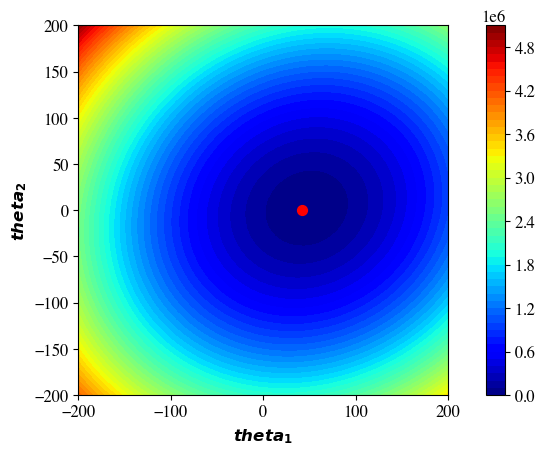

In [23]:
plt.rcParams['axes.grid'] = False
plt.contourf(xxt, yyt, losses, levels=50, cmap='jet')
plt.colorbar()
plt.scatter(coef_gt, 0, color='red', marker='o', s=50)
plt.axis('scaled')
plt.xlabel('$theta_1$')
plt.ylabel('$theta_2$');

# Ready for an awesome demo?

<IPython.core.display.Javascript object>


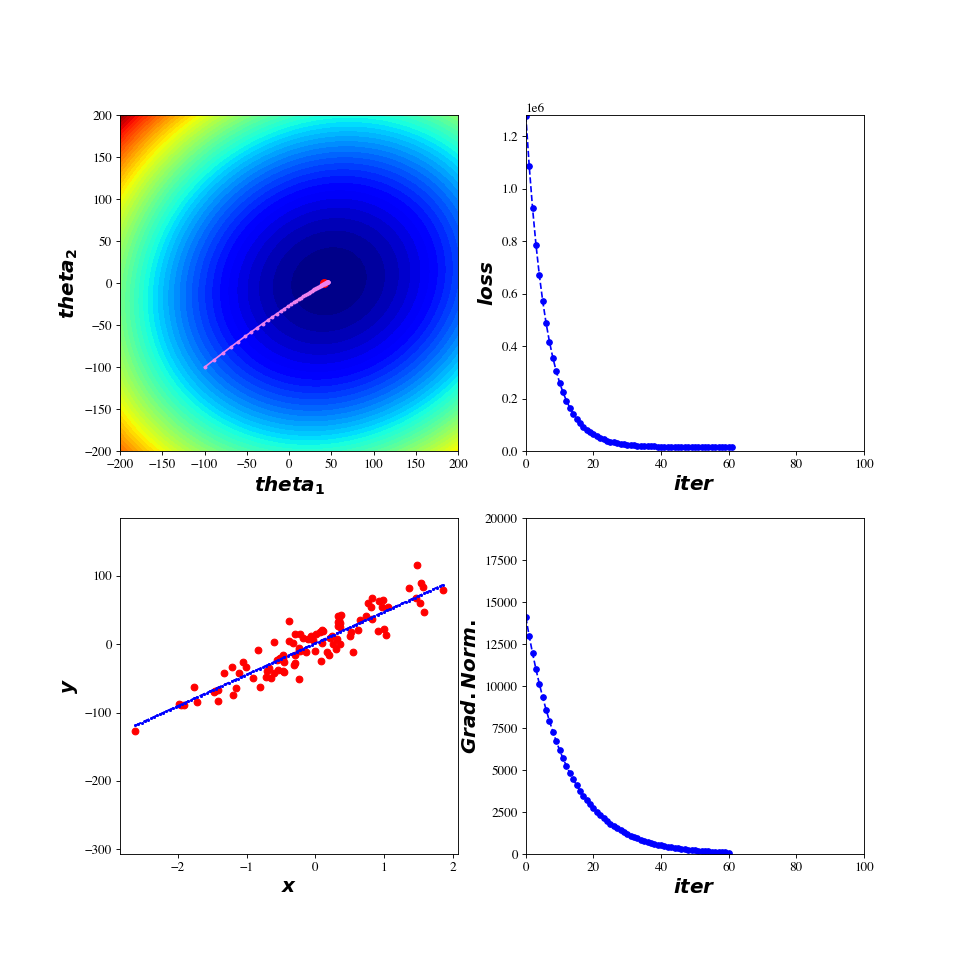

[46.09610615] [1.80913084]


In [24]:
## Implementation of Gradient Descent for Logistic Regression

import time
%matplotlib notebook


def get_diff(X, theta, y):
    return X@theta - y[..., np.newaxis]


def get_loss(diff): 
    return 0.5*np.dot(diff.T, diff)


def plot_line(plot3, theta):
    x_interp = np.linspace(Xmin, Xmax, 100)
    x_interp = x_interp.reshape(-1, 1)
    x_interp = np.c_[x_interp, np.ones_like(x_interp)]
    y_interp = np.dot(x_interp, theta)
    if plot3:
        plot3.set_xdata(x_interp[:, 0])
        plot3.set_ydata(y_interp)
    else:
        return x_interp, y_interp

Xmin, Xmax = X.min(), X.max()
plt.ion()
figure, (axes_1, axes_2) = plt.subplots(2, 2, figsize=(12, 12))
plt.rcParams['axes.grid'] = False
ax0, ax1 = axes_1
ax2, ax3 = axes_2
ax0.contourf(xxt, yyt, losses, levels=50, cmap='jet')
ax0.scatter(coef_gt, 0, color='red', marker='o', s=50)
ax0.set_xlabel('$theta_1$',fontsize=18)
ax0.set_ylabel('$theta_2$',fontsize=18)
ax1.set_ylabel('$loss$',fontsize=18)
ax1.set_xlabel('$iter$',fontsize=18)
ax1.set(xlim=(0, 100), ylim=(0, 1.28e6))
ax2.scatter(X[..., 0], y, c='red', marker='o')
ax2.set_xlabel('$x$',fontsize=18)
ax2.set_ylabel('$y$',fontsize=18)
ax3.set_ylabel('$Grad. Norm.$',fontsize=18)
ax3.set_xlabel('$iter$',fontsize=18)
ax3.set(xlim=(0, 100), ylim=(0, 20000))

theta_curr = np.array([[-100, -100]]).T
losses_track = [get_loss(get_diff(X, theta_curr, y))]
grad_norm_track = [1000]

theta_track = np.array(theta_curr)
lr = 1e-3
loss_tol = 10

plot1, = ax0.plot(*theta_curr, color='violet',
                  marker='.', markersize=5, linestyle='-')
plot2, = ax1.plot(*losses_track, color='blue',
                  marker='.', markersize=10, linestyle='--')
xi, yi = plot_line(None, theta_curr)
plot3a,plot3b = ax2.plot(xi, yi, color='blue', marker='.',
                  markersize=3, linestyle='--')
plot4, = ax3.plot(1000, color='blue',
                  marker='.', markersize=10, linestyle='--')
while True:
    diff = get_diff(X, theta_curr, y)
    grad = (diff * X).sum(axis=0, keepdims=True).T
    theta_curr = theta_curr - lr*grad
    theta_track = np.append(theta_track, theta_curr, axis=1)
    diff = get_diff(X, theta_curr, y)
    losses_track.append(get_loss(diff))
    grad_norm_track.append(np.linalg.norm(grad,2))
    if abs(losses_track[-2]-losses_track[-1]) < loss_tol:
        break
    plot1.set_xdata(theta_track[0, :])
    plot1.set_ydata(theta_track[1, :])
    plot2.set_xdata(range(len(losses_track)))
    plot2.set_ydata(losses_track)
    plot4.set_xdata(range(len(grad_norm_track[1:])))
    plot4.set_ydata(grad_norm_track[1:])
    plot_line(plot3a, theta_curr)
    plot_line(plot3b, theta_curr)
    figure.canvas.draw()
    figure.canvas.flush_events()
    time.sleep(0.1)
print(*theta_curr)
plt.show()

# Let's go back to word2vec

# Introduction to word2vec

- We have a very **large corpus** on which we apply **self-supervision**
   - The corpus defines the vocabulary $V$.
- Every word in $V$ is represented as a vector in a $D$ dimensional    vector space 
   - e.g. D = 100.
- The parametric model $\bmf{\theta}$ that we learn **depends on all vectors for all the words**

# word2vec is a generic framework 

`word2vec` presents two algorithms:
 1. **Skip-Gram** _(we see it today!)_
 2. Continuous Bag-of-Word (CBOW)
 

<br>

Also it offers different training methods:
 - **with softmax**  _(we see it today!)_
 - negative sampling from [Mikolov et al. 2013]
 - hierarchical softmax

# word2vec: Skip-Gram with softmax

Parameters to learn: $$\bmf{\theta} = [\bmf{\theta}_W;\bmf{\theta}_C]$$

<div align='center'><img src="figs/word2vec_params.png" width='65%' ></div>

# word2vec: Skip-Gram with softmax

Parameters to learn:   $\bmf{\theta} = [\bmf{\theta}_W;\bmf{\theta}_C]$

- $\bmf{\theta}_W$ is a matrix $|V|\times D$ where we store a vector in D dimensions for each word of the vocabulary $V$. We store vectors when the word $w$ works as a **$\underline{center}$**.
- $\bmf{\theta}_C$ is a matrix $|V|\times D$ where we store a vector in D dimensions for each word of the vocabulary $V$. We store vectors when the word $w$ works as the **$\underline{context}$**.

Thus the number of parameters to learn $\bmf{\theta}$ is $\quad 2\cdot|V|\cdot D$


# Sample question you may find in the exam

Given a **word2vec** model with **skip-gram** that learns word embedding $\bmf{\theta}_i\Rd{10}$ with a vocabulary of $100$ words, how many parameters word2vec needs to be learned? What is the dimension of the matrix learned?

## Answer

word2vec learns two vectors for each word in the vocabulary. One vector in case the word is considered as target; one vector in case the word functions as context. Given that the vectors are in 10-D space, the number of params is $2\cdot10\cdot100 = 2000$.
The matrix $\bmf{\theta}$ shape is $2\cdot100 \times 10$, where each row indicates a word in the vocabulary.

# word2vec: Skip-Gram Self-Supervision

We start from a large corpus of text:

`... lemon, a tablespoon of apricot jam, a pinch ...`

and a window that defines the context (let's assume window size is $m=2$ and centered at the index $t$).

# word2vec: Skip-Gram Self-Supervision

Given a window size of $m=2$ words as **context**, we select:
- the center word $w_t$, apricot in this case.
- 2 words as context on the left of $w_t$ $\longrightarrow$ ($w_{t-2}$, $w_{t-1}$)
- 2 word as context on the right of $w_t$ $\longrightarrow$ ($w_{t+1}$, $w_{t+2}$)

|   | ~~lemon~~, | ~~a~~ | [tablespoon | of | apricot | jam | a] | ~~pinch~~ |
|:-:|:------:|:-:|:-----------:|:--:|:-------:|:---:|:--:|:-----:|
|   |        |   |      w_{t-2}     | w_{t-1} |    **$w_t$**    |  w_{t+1} | w_{t+2} |       |



# word2vec: Skip-Gram Self-Supervision

|   | ~~lemon~~, | ~~a~~ | [tablespoon | of | apricot | jam | a] | ~~pinch~~ |
|:-:|:------:|:-:|:-----------:|:--:|:-------:|:---:|:--:|:-----:|
|   |        |   |      w_{t-2}     | w_{t-1} |    **$w_t$**    |  w_{t+1} | w_{t+2} |       |

Let's assume the vocabulary is made of $|V|$ words:

| word1   	| word2 	| word3             	| ...	 | wordN	|
|----------	|--------	|--------------------	|--------	|--------	|
| lemon | tablespoon | gelato  | ... | jam |

Note: $|V|$ is possibly in the order of millions.

# word2vec: Skip-Gram Self-Supervision
<br/>
$$ p(w_{t-2},w_{t-1},w_{t+1},w_{t+2}|w_t=\text{apricot};\bmf{\theta})$$
<br/><br/>

|   | ~~lemon~~, | ~~a~~ | [tablespoon | of | apricot | jam | a] | ~~pinch~~ |
|:-:|:------:|:-:|:-----------:|:--:|:-------:|:---:|:--:|:-----:|
|   |        |   |      w_{t-2}     | w_{t-1} |    **$w_t$**    |  w_{t+1} | w_{t+2} |       |


# word2vec: Skip-Gram Self-Supervision

⚠️ With **strong naive conditional independence assumption** 
<br/>

$$ p(w_{t-2},w_{t-1},w_{t+1},w_{t+2}|w_t;\bmf{\theta}) \approx \prod_{-m\leq j\leq m} p(c_{t+j}|w_t;\bmf{\theta})$$

<br/>

|   | ~~lemon~~, | ~~a~~ | [tablespoon | of | apricot | jam | a] | ~~pinch~~ |
|:-:|:------:|:-:|:-----------:|:--:|:-------:|:---:|:--:|:-----:|
|   |        |   |      w_{t-2}     | w_{t-1} |    **$w_t$**    |  w_{t+1} | w_{t+2} |       |


# word2vec: Skip-Gram Self-Supervision

Given the example below, we have to compute:
<br/>

$$p(w_{t-2}|w_t)\cdot p(w_{t-1}|w_t)\cdot p(w_{t+1}|w_t)\cdot p(w_{t+2}|w_t)$$
<br/>

|   | ~~lemon~~, | ~~a~~ | [tablespoon | of | apricot | jam | a] | ~~pinch~~ |
|:-:|:------:|:-:|:-----------:|:--:|:-------:|:---:|:--:|:-----:|
|   |        |   |      w_{t-2}     | w_{t-1} |    **$w_t$**    |  w_{t+1} | w_{t+2} |       |


# word2vec: Skip-Gram Self-Supervision

Given the example below, we have to compute:
<br/>

$$p(w_{t-2}|w_t)\cdot p(w_{t-1}|w_t)\cdot p(w_{t+1}|w_t)\cdot p(w_{t+2}|w_t)$$
<br/><br/>
<div align='center'><img src="figs/word2vec_skipgram.png" width='65%' ></div>

# How to compute $p(w_{t-1}|w_{t})$?
$$ p(w_{t-1}|w=\text{apricot})$$

We have to predict $w_{t-1}$ given the center word $w_t$. Note $w_{t-1}$ can takes values based on the words in $V$. 

Think $w_{t-1}$ as a **categorical variable** where its possible state spans $V$.

| word1   	| word2 	| word3             	| ...	 | wordN	|
|----------	|--------	|--------------------	|--------	|--------	|
| lemone | tablespoon | gelato  | ... | jam |

# How to compute $p(w_{t-1}|w_{t})$?
1. $i$ is the index of the center word $w$ in $V$ and also $\bmf{\theta}_{W}$. **Compare the embedding of $w$ as center word $\bmf{\theta}_{W}[i]$ vs embeddings of all context words $\bmf{\theta}_{C}$**  with matrix to vector product.
$$\underbrace{\mbf{z}}_{|V|\times 1}=\overbrace{\underbrace{\bmf{\theta}_C}_{|V|\times D}}^{\text{as context}}\cdot\overbrace{\underbrace{\bmf{\theta}_{W}[i]^T}_{D\times 1}}^{\text{as center}} $$

2. $\mbf{z}$ is logits and encodes the similarity via dot product of the center word embedding $\bmf{\theta}_{W}[i]$ **against all vocabulary words** taken as context $\bmf{\theta}_C$

3. We pass $\mbf{z}$ through softmax operator to get a distribution over $|V|$ as: $$\mbf{p}=\operatorname{softmax}(\mbf{z}) $$

You can think $\mbf{p}$ as of this form:

|    	| lemon   	| tablespoon 	| gelato             	| ...	 | jam	|
|----------|----------	|--------	|--------------------	|--------	|--------	|
|**p** | 0.001 | 0.1 | 0.03  | ... | 0.15 |

# How to compute $p(w_{t-1}|w_{t})$?
 
$$\mbf{p}=\operatorname{softmax}\big(\bmf{\theta}_C\cdot\bmf{\theta}_{W}[i]^T\big) $$

You can think $\mbf{p}$ as of this form:

|    	| lemon   	| tablespoon 	| gelato             	| ...	 | jam	|
|----------|----------	|--------	|--------------------	|--------	|--------	|
|**p** | 0.001 | 0.1 | 0.03  | ... | 0.15 |

🤔 Note: until now we did not used the self-supervised label! We did not use the **ground-truth index for $w_{t-1}$**. (i.e. the fact that $w_{t-1}$ is actually `tablespoon`!

|   | ~~lemon~~, | ~~a~~ | [tablespoon | of | apricot | jam | a] | ~~pinch~~ |
|:-:|:------:|:-:|:-----------:|:--:|:-------:|:---:|:--:|:-----:|
|   |        |   |      w_{t-2}     | w_{t-1} |    **$w_t$**    |  w_{t+1} | w_{t+2} |       |

# Loss function: compare two discrete distributions
 
$$\mbf{p}=\operatorname{softmax}\big(\bmf{\theta}_C\cdot\bmf{\theta}_{W}[i]^T\big) $$

You can think $\mbf{p}$ as of this form:

|    	| lemon   	| tablespoon 	| gelato             	| ...	 | jam	|
|----------|----------	|--------	|--------------------	|--------	|--------	|
|**p (word2vec prediction)**        | 0.001 | 0.1 | 0.03  | ... | 0.15 |


Let's consider the label as a one-hot encoding vector where 1 is over the ground-truth word given by the text.

|    	| lemon   	| tablespoon 	| gelato             	| ...	 | jam	|
|----------|----------	|--------	|--------------------	|--------	|--------	|
|**y label (ground-truth $w_{t-1}$)** | 0 | 1 | 0  | ... | 0 |

### We want to adjust the weights $\bmf{\theta}$ so that $\mbf{p}$ matches the label!

# Loss function: compare two discrete distributions
## In this example $V$ has two words

Who can tell me how we can compare two _[discrete]_ probability distributions? We use **cross-entropy.**
<br><br>
<div align='center'><img src="figs/distributions.png" width='65%' ></div>

# Loss function: Cross-entropy (CE)

- $\mbf{y}=[0,0,0,1,0]$ is the **one-hot encoding of the labels** $\rightarrow$ This is self-supervised by the text itself!
- $\mbf{p}(w_{t-1}|w_{t})=[0.1, 0.1, 0.1, 0.35, 0.35]$ is the output from `word2vec`. We want $\mbf{p}$ to match $\mbf{y}$.
<br><br>
$$ 
\mathcal{L}(w_{t-1},w_{t};\mbf{\theta})=-\mbf{y}^{\top} \log\big(\mbf{p}(w_{t-1}|w_{t}) \big)
$$
<br><br>
$$-0\cdot\ln(0.1)-0\cdot\ln(0.1)-0\cdot\ln(0.1)\underbrace{-1\cdot\ln(0.35)}_{\text{only this matter}}-0\cdot\ln(0.35)=-1\cdot\ln(0.35)\approx1.04$$

# One-hot encoding is a selector!


- $\mbf{y}=[0,0,0,1,0]$ $\rightarrow$ works as a selector of probability of the actual ground-truth word that we removed!
- Of the probabilites returned by `word2vec` select that for which the index $gt$ corresponds to the `1` in the label $\mbf{y}$
- in our case, $gt$ is the index of `tablespoon` in $|V|$.

$$ \mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = -\log \mbf{p}\big(w_{t-1}|w_{t}\big){[gt]}$$

# Loss function simplified

We can select immediately $[gt]$ in the numerator.

$$
\mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = -\log \left(\frac{\exp \big( \bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T \big)}{\sum_{v=1}^{V} \exp \big(\bmf{\theta}_{C}[v]\cdot\bmf{\theta}_{W}[i]^T\big)}\right)
$$

Sometimes is shown as:

$$
\mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = \underbrace{-\bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T}_{\text{similarity center vs context}} + \underbrace{\log\Big(\sum_{v=1}^{V} \exp \big(\bmf{\theta}_{C}[v]\cdot\bmf{\theta}_{W}[i]^T\big)\Big)}_{\text{make sure it is a probability}}
$$

# Exercise A: compute the loss for a center word in word2vec
 
$$\mbf{p}=\operatorname{softmax}\big(\bmf{\theta}_C\cdot\bmf{\theta}_{W}[i]^T\big) $$

You can think $\mbf{p}$ as of this form:

|    	| lemon   	| tablespoon 	| gelato             	| ...	 | jam	|
|----------|----------	|--------	|--------------------	|--------	|--------	|
|**p (word2vec prediction)**        | 0.001 | 0.1 | 0.03  | ... | 0.15 |


Let's consider the label as a one-hot encoding vector where 1 is over the ground-truth word given by the text.

|    	| lemon   	| tablespoon 	| gelato             	| ...	 | jam	|
|----------|----------	|--------	|--------------------	|--------	|--------	|
|**y label (ground-truth)** | 0 | 1 | 0  | ... | 0 |

$$ \mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = -\log \mbf{p}\big(w_{t-1}|w_{t}\big){[gt]} = -\ln(0.1)\approx 2.30$$

# Exercise B: similar but more complex

We give 2D matrix of $\theta_W$ and $\theta_C$, the position of the center word and context word, compute the loss.

# Likelihood over a window

Likelihood of the data given the parameters. 
$$L(\bmf{\theta})=p\big(w_{t-2},w_{t-1},w_{t+1},w_{t+2}|w;\bmf{\theta}\big) \approx \prod_{-m\leq j\leq m, j \neq 0}p(w_{t+j}|w_{t};\bmf{\theta})$$

We seek the parameters $\bmf{\theta}$ that maximizes the likelihood of the data.

$$ \bmf{\theta}^{\star} = \arg\max_{\bmf{\theta}} L(\bmf{\theta})=p\big(w_{t-2},w_{t-1},w_{t+1},w_{t+2}|w;\bmf{\theta}\big)$$

# Loss function over a window

$$\bmf{\theta}^{\star} = \arg\max_{\bmf{\theta}} L(\bmf{\theta})= \prod_{-m\leq j\leq m, j \neq 0}p(w_{t+j}|w_{t};\bmf{\theta}) $$

Logarithm is a strictly monotonic function so we can flip the sign, apply the $\log()$ and **minimize the loss instead:**

### Minimize the cross-entropy loss $\leftrightarrow$ maximizing the likelihood of the data given the parameters
<br>
$$\bmf{\theta}^{\star} = \arg\min_{\bmf{\theta}} \mathcal{L}(\bmf{\theta})=-\sum_{-m\leq j\leq m, j \neq 0} \log\big(p(w_{t+j}|w_t;\bmf{\theta})\big)$$

# Loss over a window, over all possible windows

We iterate over all possibile center words with $t \in \{1\ldots T\}$ maximizing the likelihood:
$$\bmf{\theta}^{\star} = \arg\max_{\bmf{\theta}} L(\bmf{\theta})= \prod_{t=1}^T\prod_{-m\leq j\leq m, j \neq 0}p(w_{t+j}|w_{t};\bmf{\theta}) $$

In practice, we minimize the average negative log-likelihood (loss):

$$\bmf{\theta}^{\star} = \arg\min_{\bmf{\theta}} \mathcal{L}(\bmf{\theta})=-\frac{1}{T}\sum_{t=1}^T\sum_{-m\leq j\leq m, j \neq 0} \log\big(p(w_{t+j}|w_t;\bmf{\theta})\big)$$


### Minimize the cross-entropy loss is $\leftrightarrow$ maximizing the likelihood of the data given the parameters

# We optimize the loss with SGD

$$\bmf{\theta}^{\star} = \arg\min_{\bmf{\theta}} \mathcal{L}(\bmf{\theta})=-\frac{1}{T}\sum_{t=1}^T\sum_{-m\leq j\leq m, j \neq 0} \log\big(p(w_{t+j}|w_t;\bmf{\theta})\big)$$

To optimize our $\bmf{\theta}$ we have to make a small step in the negative direction of the gradient:

$$\bmf{\theta} \leftarrow  \bmf{\theta} -\gamma \bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};w_{t-1},w_t)$$

Pseudo-code of the training:

```python
gamma = 1e-3
while not converged:
    loss = word2vec(corpus, theta)
    theta_grad = evaluate_gradient(loss, corpus, theta)
    theta = theta - gamma*theta_grad
```

## Example: compute the gradient of the loss wrt center word embedding 

Define $\mbf{u}_c\doteq\bmf{\theta}_{W}[i]$ and $\mbf{u}_o \doteq \bmf{\theta}_{C}[gt]$. Compute the gradient of the loss wrt. to the embedding of the center word $\mbf{u}_c$

$$
\nabla_{\mbf{u}_c} \mathcal{L}(\mbf{u}_c,\mbf{u}_o) =  \nabla_{\mbf{u}_c} -\log \left(\frac{\exp \big( \mbf{u}_o\cdot\mbf{u}_c^T \big)}{\sum_{v=1}^{V} \exp \big(\mbf{u}_v\cdot\mbf{u}_c^T\big)}\right)
$$

Continue on the whiteboard

# word2vec with Skip-Gram at a glance

... and why it can be seen as a tiny neural net.

<div align='center'><img src="figs/word2vec_layers.png" width='65%' ></div>

# word2vec learned space

word2vec minimizes the loss function by putting similar words (words that happen in same context) nearby in space


<div align='center'><img src="figs/word2vec_space.png" width='65%' ></div>
<small>Taken from Stanford slide<small>

# Let's play with word2vec

# Show available models in Gensim

You need Gensim.

In [25]:
import gensim.downloader
# Show all available models in gensim-data
list(gensim.downloader.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

# Let's play with word2vec

This is a word2vec trained on entire Google News dataset, of about **100 billion words.**

`word2vec-google-news-300`

Model is 1.6GB so it will take time to download (it will show progress bar)!



In [26]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')
# [==================================================] 100.0% 1662.8/1662.8MB downloaded

# The vocabulary

In [27]:
N = len(wv.index_to_key)
print(f'vocabulary size is {N}')

for index, word in enumerate(wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index} over {N} is {word}")

vocabulary size is 3000000
word #0 over 3000000 is </s>
word #1 over 3000000 is in
word #2 over 3000000 is for
word #3 over 3000000 is that
word #4 over 3000000 is is
word #5 over 3000000 is on
word #6 over 3000000 is ##
word #7 over 3000000 is The
word #8 over 3000000 is with
word #9 over 3000000 is said


# Accessing a word embedding

In [28]:
vec_king = wv['king']
print(f'vector shape is {vec_king.shape}')

vector shape is (300,)


In [29]:
import pandas as pd
pd.DataFrame(dict(king=vec_king.tolist())).T

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
king,0.125977,0.029785,0.008606,0.139648,-0.025635,-0.036133,0.111816,-0.198242,0.05127,0.363281,...,-0.004669,-0.244141,-0.209961,-0.287109,-0.04541,-0.177734,-0.279297,-0.085938,0.091309,0.251953


Watch out if you do not pass before through the vocabulary before asking the model

In [30]:
try:
    vec_cameroon = wv['cameroon']
except KeyError:
    print("The word 'cameroon' does not appear in this model")

The word 'cameroon' does not appear in this model


# Word similarities!

In [31]:
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
    ('car', 'cartoon'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv.similarity(w1, w2)))

'car'	'minivan'	0.69
'car'	'bicycle'	0.54
'car'	'airplane'	0.42
'car'	'cereal'	0.14
'car'	'communism'	0.06
'car'	'cartoon'	0.03


# Most similar

In [32]:
wv.most_similar(positive=['car', 'minivan'], topn=5)

[('SUV', 0.8532192707061768),
 ('vehicle', 0.8175783753395081),
 ('pickup_truck', 0.7763688564300537),
 ('Jeep', 0.7567334175109863),
 ('Ford_Explorer', 0.7565720081329346)]

# Outlier detection

In [33]:
wv.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car'])

'car'

# Analogy using the learned embedding space

- word2vec learns relationships between words automatically
- Arithmetic of the vectors has surprising properties!

`a is to b as a* is to what?`

`Man is to King as Woman is to ______`

### Algebric way

$$\bmf{\theta}_W(\text{king}) - \bmf{\theta}_W(\text{man}) + \bmf{\theta}_W(\text{woman}) \approx \bmf{\theta}_W(\text{queen})$$

# Analogy using the learned embedding space
### Geometric way (parallelogram model)
<div align='center'><img src="figs/word2vec_analogy.png" width='35%' ></div>

# Analogy using the learned embedding space
### Optimization
$$ \mbf{a}:\mbf{b} = \mbf{a}^{\star}: \mbf{b}^{\star}? $$

$$ \mbf{b}^{\star} = \arg\max_{\mbf{x}} \text{sim}(\mbf{x},\mbf{b}-\mbf{a}+\mbf{a}^{\star})$$
 
<div align='center'><img src="figs/word2vec_analogy.png" width='35%' ></div>

# Analogy

In [34]:
def analogy(x1, x2, y1):
    result = wv.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [35]:
analogy('man', 'king', 'woman')

'queen'

In [36]:
analogy('australia', 'beer', 'france')# does not work well with Glove should give you champagne


'beers'

In [37]:
analogy('obama', 'clinton', 'reagan')

'kerry'

In [38]:
analogy('tall', 'tallest', 'long')

'longest'

In [39]:
analogy('good', 'fantastic', 'bad')

'horrible'